# Домашнее задание (10 баллов)


(2 балла)
1. закончить реализацию `ClassificationDecisionTree` в decision_tree
    1. реализовать feature_importance_ (для этого метода теста нет, подойдет реализацию любого варианта, базовый способ - рекурсивно суммировать по всем `self.feature_id` `self.q_value_max` и вывести суммы. 
    2. проверить корректность predict 
2. реализовать `BaseSampler`, `ObjectSampler` и `FeatureSampler`. `BaseSampler` - базовый класс, у которого должен быть реализован метода `sample_indices` - вернуть индексы сэмплов. `ObjectSampler` сэплирует объекты, `FeatureSampler` - признаки.
3. реализовать `RandomForestClassifier` в random_forest (predict/predict_proba).

Обратите внимение, что в random_forest в качестве `base_estimator` предполагается использовать `DecisionTreeClassifier` из sklearn, использовать вашу реализацию решающего дерева необязательно. <br> Пример запуска тестов 
- `python -m unittest discover sem_dt_rf/decision_tree/tests`
- `python -m unittest discover sem_dt_rf/random_forest/tests` 

Или через `pytest`
- `python -m pytest sem_dt_rf/decision_tree/tests/test_criterio.py`

(1 балл) Для регрессионного дерева необходимо использовать такой критерий:
$$H(R) = \min_c \frac{1}{|R|} \sum_{(x_i, y_i) \in R} (y_i - c)^2$$

Докажите, что минимум H(R) достигается при $c$:


$$ c = \frac{1}{|R|} \sum_{(x_j, y_j) \in R} y_j$$

Решение: Это задача минимизации без оганицений, значит можно построить лагранжиан(это и есть сама целевая функция), условия стационарности выполнено, а дополняющей нежесткости и неотрицательности просто нет, так как нет и условий оптимизации. Тогда можно просто дифференцировать по с и приравнивать к 0, выраженая с и будет ответом. 
$$\frac{d \sum_{(x_i, y_i) \in R} (y_i - c)^2}{|R| dc} = \frac{-2}{|R|} \sum_{(x_i, y_i) \in R}( y_i - c ) = 0$$

Сократим константу

$$ \sum_{(x_i, y_i) \in R} y_i - \sum_{(x_i, y_i) \in R} c = \sum_{(x_i, y_i) \in R}y_i -|R|c = 0$$

Тогда:

$$c = \frac{1}{|R|} \sum_{(x_i, y_i) \in R} y_i$$

(3 балла) Реализуйте регрессионное дерево. В качестве критерия необходимо использовать критерий, определённый в пункте 2, в коде есть заглушка `MSECriterion`. В качестве `predict` необходимо использовать среднее значение ответов по всем объектам в листе. В коде нет готовой заглушки, реализуйте по аналогии с `class ClassificationDecisionTree(DecisionTree):`.

Сгенерируйте однопризнаковую выборку для тестирования дерева и покажите работу дерева на этой выборке (пример см. ниже, можно использовать свою версию). Отобразите на одном графике `predict` алгоритма и значение признака. Что меняется при изменении параметра глубины? Сделайте выводы.

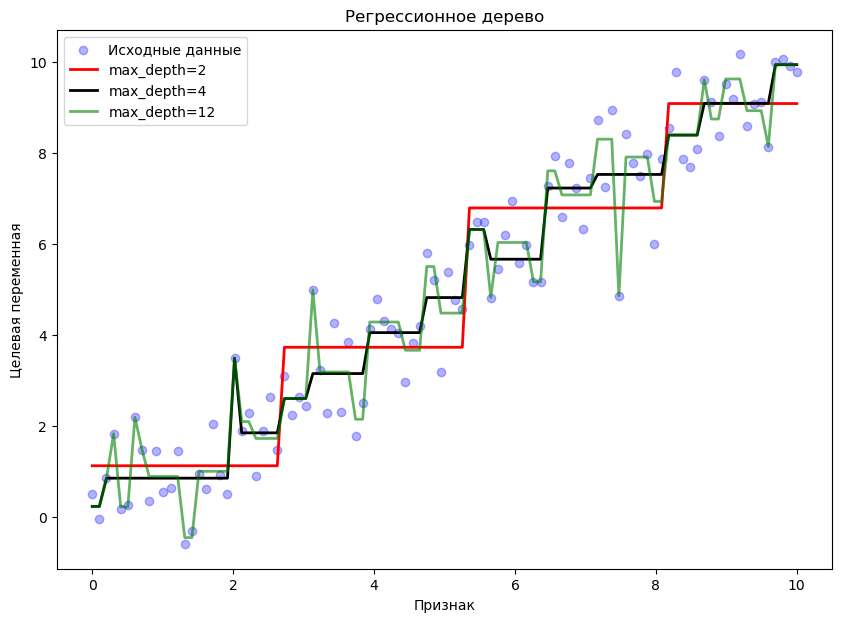

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sem_dt_rf.decision_tree.decision_tree import RegressionDecisionTree

np.random.seed(42)
n = 100
X = np.linspace(0, 10, n)
y = X + np.random.normal(0, 1, n)

X = X.reshape(-1, 1)

tree_2 = RegressionDecisionTree(max_depth=2)
tree_2.fit(X, y)
y_pred_2 = tree_2.predict(X)

tree_4 = RegressionDecisionTree(max_depth=4)
tree_4.fit(X, y)
y_pred_4 = tree_4.predict(X)

tree_12 = RegressionDecisionTree(max_depth=12)
tree_12.fit(X, y)
y_pred_12 = tree_12.predict(X)


plt.figure(figsize=(10, 7))
plt.scatter(X, y, label="Исходные данные", color="blue", alpha=0.3)

plt.plot(X, y_pred_2, label="max_depth=2", color="red", linewidth=2)
plt.plot(X, y_pred_4, label="max_depth=4", color="black", linewidth=2)
plt.plot(X, y_pred_12, label="max_depth=12", color="green", linewidth=2, alpha=0.6)
6
plt.xlabel("Признак")
plt.ylabel("Целевая переменная")
plt.legend()
plt.title("Регрессионное дерево")
plt.show()


Можно побаловаться с глубиной дерева и внезапно окажется, что дерево склонно переобучатся, зеленый график сильно навязчивый так что я его сделал полупрозрачным. Кажется что значения глубины 3-4 адекватные. При значениях 1-2 все примитивно: 1 это просто ступенька, а 2 это две ступеньки. Грубина 4 все еще ступеньки, но при этом кое где черный график достает отдельные значения, как например на х=2(что плохо), в то же время есть выступ гдето на х=5.75, там график потянулся к нескольким значениям(это уже хорошо, он предсказает тренд а не переобучается). Зеленый это жесть, естественно он тянется ко всем точкам и в итоге ошибка на тесте будет большой. 

Но не будем разглагольствовать и все проверим

In [62]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

np.random.seed(42)
n_ = 100
X = np.linspace(0, 20, n_)
y = X + np.random.normal(0, 1, n_)

X = X.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)

depths = [1, 2, 3, 4, 5, 6, 8, 10, 12, 100]
for d in depths:
    tree = RegressionDecisionTree(max_depth=d)
    tree.fit(X_train, y_train)

    y_train_pred = tree.predict(X_train)
    y_test_pred = tree.predict(X_test)

    train_error = mean_squared_error(y_train, y_train_pred)
    test_error = mean_squared_error(y_test, y_test_pred)

    print(f"Depth={d}: Train MSE={train_error:.2f}, Test MSE={test_error:.2f}")


Depth=1: Train MSE=8.97, Test MSE=7.74
Depth=2: Train MSE=2.41, Test MSE=2.99
Depth=3: Train MSE=0.81, Test MSE=1.23
Depth=4: Train MSE=0.48, Test MSE=0.86
Depth=5: Train MSE=0.45, Test MSE=0.87
Depth=6: Train MSE=0.42, Test MSE=0.98
Depth=8: Train MSE=0.38, Test MSE=1.04
Depth=10: Train MSE=0.38, Test MSE=1.04
Depth=12: Train MSE=0.38, Test MSE=1.04
Depth=100: Train MSE=0.38, Test MSE=1.04


Видно что при малых глубинах ошибка на тесте здоровая, оно и понятно. Минимум достигается на d=4, а дальше начинается переобучение которое достикает своего пика на d=8.

Теперь тест посложнее:

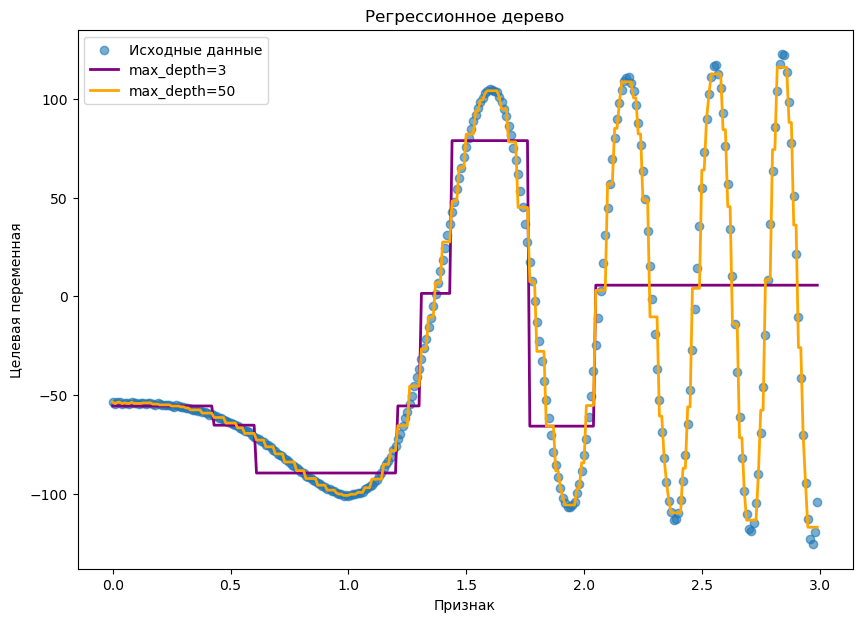

In [106]:
# generate example
x_shape = 300
x = np.arange(x_shape) / 100
y = (x**3 + 100) * np.sin(x**3 + 10) + np.random.random(x_shape)

x = x.reshape(-1, 1)

tree_3 = RegressionDecisionTree(max_depth=3)
tree_3.fit(x, y)
y_pred_3 = tree_3.predict(x)

tree_50 = RegressionDecisionTree(max_depth=50)
tree_50.fit(x, y)
y_pred_50 = tree_50.predict(x)



plt.figure(figsize=(10, 7))
plt.scatter(x, y, label="Исходные данные", alpha=0.6)

plt.plot(x, y_pred_3, label="max_depth=3", color="purple", linewidth=2)
plt.plot(x, y_pred_50, label="max_depth=50", color="orange", linewidth=2)


plt.xlabel("Признак")
plt.ylabel("Целевая переменная")
plt.legend()
plt.title("Регрессионное дерево")
plt.show()

In [107]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.33, random_state=42)

depths = [1, 3, 5, 6, 8, 10, 13, 16, 20, 25, 30, 40, 50]
for d in depths:
    tree = RegressionDecisionTree(max_depth=d)
    tree.fit(X_train, y_train)

    y_train_pred = tree.predict(X_train)
    y_test_pred = tree.predict(X_test)

    train_error = mean_squared_error(y_train, y_train_pred)
    test_error = mean_squared_error(y_test, y_test_pred)

    print(f"Depth={d}: Train MSE={train_error:.2f}, Test MSE={test_error:.2f}")

Depth=1: Train MSE=3633.37, Test MSE=3384.91
Depth=3: Train MSE=2463.79, Test MSE=2199.18
Depth=5: Train MSE=1512.26, Test MSE=1797.51
Depth=6: Train MSE=479.07, Test MSE=599.69
Depth=8: Train MSE=108.37, Test MSE=226.97
Depth=10: Train MSE=87.63, Test MSE=206.65
Depth=13: Train MSE=83.64, Test MSE=207.86
Depth=16: Train MSE=83.64, Test MSE=207.86
Depth=20: Train MSE=83.64, Test MSE=207.86
Depth=25: Train MSE=83.64, Test MSE=207.86
Depth=30: Train MSE=83.64, Test MSE=207.86
Depth=40: Train MSE=83.64, Test MSE=207.86
Depth=50: Train MSE=83.64, Test MSE=207.86


Оптимальное значение глубины от 10 и выше. Если ставить меньше то график не может обрабоать хвост, а если больше то он начинает захватывать самые верхние и самые нижние точки и при этом на данной задаче не переобучается. 

In [41]:
from sem_dt_rf.decision_tree.tests.test_tree_node import TestTreeNode
from sem_dt_rf.decision_tree.tests.test_decision_tree import TestDecisionTree, TestRegressionTree
from sem_dt_rf.decision_tree.tests.test_criterio import TestGiniCriterion, TestEntropyCriterion, TestMSECriterion

test1 = TestTreeNode()
test1.test_get_best_split()

test2 = TestDecisionTree()
test2.test_small_decision_tree()
test2.test_decision_tree()

test3 = TestRegressionTree()
test3.test_small_regression_tree()
test3.test_regression_tree()
test3.test_feature_importance()

test4 = TestGiniCriterion()
test4.test_gini_get_predict_val()
test4.test_gini_score()
test4.test_gini_get_best_split()
test4.test_gini_get_best_split_2()

test5 = TestEntropyCriterion()
test5.test_entropy_get_predict_val()
test5.test_entropy_score()
test5.test_entropy_get_best_split()
test5.test_entropy_get_best_split_v2()

test6 = TestMSECriterion()
test6.test_mse_get_predict_val()
test6.test_mse_score()
test6.test_mse_get_best_split()
test6.test_mse_get_best_split_v2()

c:\Users\Admin\OneDrive\Рабочий стол\AIM 2сем\ML2\hw1\sem_dt_rf\decision_tree\criterio.py:72: RuntimeWarning: invalid value encountered in divide
  return np.bincount(target, minlength=self.n_classes) / target.shape[0]
c:\Users\Admin\OneDrive\Рабочий стол\AIM 2сем\ML2\hw1\sem_dt_rf\decision_tree\criterio.py:87: RuntimeWarning: invalid value encountered in divide
  return np.bincount(target, minlength=self.n_classes) / target.shape[0]


(4 балла) Протестируйте различные реализации `random_forest` на `fetch_covtype` датасете (можно загрузить с помощью `sklearn.datasets.fetch_covtype`). Возможно, поможет ноутбук с семинара `ensembles_seminar.ipynb`. Для честного сравнения старайтесь использовать похожий набор гиперпараметров.
- ваша реализация (import `RandomForestClassifier as MyRandomForestClassifier` ниже)
- sklearn https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- lightgbm https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMModel.html см. параметр `boosting_type`
- xgboost https://xgboost.readthedocs.io/en/stable/tutorials/rf.html

    Что нужно сделать: 
- Разбейте данные на train и test. 
- Оцените качество алгоритмов по метрике (balanced_accuracy_score)[https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html]
- Оцените время работы `train` и `predict`
- Сделайте выводы

In [1]:
import sys
sys.path.extend(['C://Users//Admin//OneDrive//Рабочий стол//AIM 2сем//ML2//hw1'])

from sem_dt_rf.random_forest.random_forest import RandomForestClassifier as MyRandomForestClassifier

In [2]:
from sklearn.datasets import fetch_covtype
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import xgboost as xgb

In [3]:
cov_type = fetch_covtype()

X = cov_type.data
y = cov_type.target
y = y-1

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)

X_train.shape, X_test.shape

((389278, 54), (191734, 54))

In [136]:
my_rf = MyRandomForestClassifier(n_estimators = 50, max_depth=40)
my_rf.fit(X_train, y_train)
y_pred = my_rf.predict(X_test)
my_rf_acc = balanced_accuracy_score(y_test, y_pred)

print(f"MyRandomForest Balanced Accuracy: {my_rf_acc:.4f}")

MyRandomForest Balanced Accuracy: 0.8767


In [7]:
import optuna
from sklearn.metrics import balanced_accuracy_score
from joblib import parallel_backend

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 200),
        'max_objects_samples': trial.suggest_float('max_objects_samples', 0.5, 1.0),
        'max_features_samples': trial.suggest_float('max_features_samples', 0.5, 1.0),
        'max_depth': trial.suggest_int('max_depth', 10, 50),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'random_state': 42
    }

    model = MyRandomForestClassifier(**params)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracy = balanced_accuracy_score(y_test, y_pred)
    return accuracy

with parallel_backend('threading', n_jobs=4):
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=30, timeout=3600)

print("Best parameters:", study.best_params)
print("Best balanced accuracy:", study.best_value)

[I 2025-03-10 18:05:40,722] A new study created in memory with name: no-name-cb81c916-2bb3-4108-91b8-447ddd4fdc00
[I 2025-03-10 18:09:44,349] Trial 0 finished with value: 0.8644255863774883 and parameters: {'n_estimators': 128, 'max_objects_samples': 0.6718917526741308, 'max_features_samples': 0.7894947691181158, 'max_depth': 44, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8644255863774883.
[I 2025-03-10 18:14:14,150] Trial 1 finished with value: 0.8752577143498353 and parameters: {'n_estimators': 87, 'max_objects_samples': 0.9831203052406291, 'max_features_samples': 0.8951826945659189, 'max_depth': 35, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.8752577143498353.
[I 2025-03-10 18:23:48,563] Trial 2 finished with value: 0.9018548195860917 and parameters: {'n_estimators': 190, 'max_objects_samples': 0.8461766585880593, 'max_features_samples': 0.9937112619958512, 'max_depth': 39, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9018548195860917.
[I 2025-03-10 18:

Best parameters: {'n_estimators': 190, 'max_objects_samples': 0.8461766585880593, 'max_features_samples': 0.9937112619958512, 'max_depth': 39, 'min_samples_leaf': 2}
Best balanced accuracy: 0.9018548195860917


In [8]:
lgb_train = lgb.Dataset(X_train, y_train)

In [ ]:
lgb_train = lgb.Dataset(X_train, y_train)

params = {
    'objective': 'multiclass',
    'num_class': 7,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'random_state': 42
}
lgb_model = lgb.train(params, lgb_train)
lgb_pred = lgb_model.predict(X_test).argmax(axis=1)
lgb_acc = balanced_accuracy_score(y_test, lgb_pred)
print(f"LightGBM Balanced Accuracy: {lgb_acc:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
LightGBM Balanced Accuracy: 0.8090


In [15]:
import lightgbm as lgb
from sklearn.metrics import balanced_accuracy_score
import optuna
from joblib import parallel_backend

# Создание LightGBM Dataset с параметром feature_pre_filter
lgb_train = lgb.Dataset(X_train, label=y_train, params={'feature_pre_filter': False})

def objective(trial):
    # Параметры для оптимизации
    params = {
        'objective': 'multiclass',
        'num_class': 7,
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 50),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 0, 1),
        'lambda_l2': trial.suggest_float('lambda_l2', 0, 1),
        'random_state': 42
    }

    # Обучение модели
    model = lgb.train(params, lgb_train, num_boost_round=1000)

    # Предсказание
    pred = model.predict(X_test).argmax(axis=1)

    # Оценка качества
    accuracy = balanced_accuracy_score(y_test, pred)
    return accuracy

# Оптимизация
with parallel_backend('threading', n_jobs=4):
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50, timeout=1800)

# Лучшие параметры
print("Best parameters:", study.best_params)
print("Best balanced accuracy:", study.best_value)

[I 2025-03-10 19:38:54,381] A new study created in memory with name: no-name-f300262c-879c-40bf-9a80-cd0ca796feb3


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-10 19:39:01,768] Trial 0 finished with value: 0.7995165462516963 and parameters: {'num_leaves': 64, 'learning_rate': 0.0406121270760585, 'n_estimators': 237, 'max_depth': 7, 'min_data_in_leaf': 24, 'feature_fraction': 0.8034294113268556, 'bagging_fraction': 0.8826031888924255, 'lambda_l1': 0.9727719546351342, 'lambda_l2': 0.5804328578808865}. Best is trial 0 with value: 0.7995165462516963.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-10 19:39:06,720] Trial 1 finished with value: 0.8787806833279285 and parameters: {'num_leaves': 65, 'learning_rate': 0.10409261911877678, 'n_estimators': 144, 'max_depth': 10, 'min_data_in_leaf': 41, 'feature_fraction': 0.7495781838985505, 'bagging_fraction': 0.5373145142393418, 'lambda_l1': 0.8160889883974483, 'lambda_l2': 0.4546988210450382}. Best is trial 1 with value: 0.8787806833279285.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-10 19:39:26,714] Trial 2 finished with value: 0.828050686698845 and parameters: {'num_leaves': 41, 'learning_rate': 0.020438025332310105, 'n_estimators': 680, 'max_depth': 8, 'min_data_in_leaf': 48, 'feature_fraction': 0.5056194788086747, 'bagging_fraction': 0.9811077186660369, 'lambda_l1': 0.3233513093148419, 'lambda_l2': 0.21689861545166145}. Best is trial 1 with value: 0.8787806833279285.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

[I 2025-03-10 19:39:48,031] Trial 3 finished with value: 0.9188253262862712 and parameters: {'num_leaves': 55, 'learning_rate': 0.09869532598662076, 'n_estimators': 639, 'max_depth': 7, 'min_data_in_leaf': 45, 'feature_fraction': 0.975326755029026, 'bagging_fraction': 0.7896493884971139, 'lambda_l1': 0.1016015226918282, 'lambda_l2': 0.00978695350638148}. Best is trial 3 with value: 0.9188253262862712.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-10 19:39:52,355] Trial 4 finished with value: 0.8916553096768931 and parameters: {'num_leaves': 45, 'learning_rate': 0.20846995575537164, 'n_estimators': 144, 'max_depth': 12, 'min_data_in_leaf': 36, 'feature_fraction': 0.8199909238381746, 'bagging_fraction': 0.7656492103281516, 'lambda_l1': 0.005589476753191436, 'lambda_l2': 0.6666256862406107}. Best is trial 3 with value: 0.9188253262862712.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-10 19:40:12,780] Trial 5 finished with value: 0.9293531824281718 and parameters: {'num_leaves': 98, 'learning_rate': 0.09731174418355629, 'n_estimators': 497, 'max_depth': 11, 'min_data_in_leaf': 34, 'feature_fraction': 0.7544827335476546, 'bagging_fraction': 0.5339401754102842, 'lambda_l1': 0.35612888245564256, 'lambda_l2': 0.24519518984756528}. Best is trial 5 with value: 0.9293531824281718.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-10 19:40:25,957] Trial 6 finished with value: 0.8996469994365347 and parameters: {'num_leaves': 59, 'learning_rate': 0.22208697613039655, 'n_estimators': 398, 'max_depth': 10, 'min_data_in_leaf': 46, 'feature_fraction': 0.638664971853688, 'bagging_fraction': 0.6647873534082829, 'lambda_l1': 0.21550784169292803, 'lambda_l2': 0.09368250325619054}. Best is trial 5 with value: 0.9293531824281718.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-10 19:40:34,516] Trial 7 finished with value: 0.8155532030223458 and parameters: {'num_leaves': 85, 'learning_rate': 0.025226197234572624, 'n_estimators': 252, 'max_depth': 9, 'min_data_in_leaf': 48, 'feature_fraction': 0.8216533377394828, 'bagging_fraction': 0.7335339143865216, 'lambda_l1': 0.19565185781825067, 'lambda_l2': 0.8279625954788423}. Best is trial 5 with value: 0.9293531824281718.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-10 19:40:42,783] Trial 8 finished with value: 0.8944208531846783 and parameters: {'num_leaves': 53, 'learning_rate': 0.2636279647010865, 'n_estimators': 258, 'max_depth': 6, 'min_data_in_leaf': 47, 'feature_fraction': 0.6014503482593174, 'bagging_fraction': 0.5867548406516568, 'lambda_l1': 0.959613600062403, 'lambda_l2': 0.998224532319384}. Best is trial 5 with value: 0.9293531824281718.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-10 19:41:00,816] Trial 9 finished with value: 0.9234779623457208 and parameters: {'num_leaves': 67, 'learning_rate': 0.10900275113008841, 'n_estimators': 521, 'max_depth': 12, 'min_data_in_leaf': 17, 'feature_fraction': 0.8822062960606125, 'bagging_fraction': 0.7149126533890421, 'lambda_l1': 0.02920448123069308, 'lambda_l2': 0.11850403110613761}. Best is trial 5 with value: 0.9293531824281718.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-10 19:41:20,042] Trial 10 finished with value: 0.8415406677003402 and parameters: {'num_leaves': 99, 'learning_rate': 0.163696403961488, 'n_estimators': 923, 'max_depth': 3, 'min_data_in_leaf': 29, 'feature_fraction': 0.6807373747501076, 'bagging_fraction': 0.5141674822916364, 'lambda_l1': 0.5865531888253288, 'lambda_l2': 0.34480151060046493}. Best is trial 5 with value: 0.9293531824281718.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092


[I 2025-03-10 19:41:32,600] Trial 11 finished with value: 0.8875222185256719 and parameters: {'num_leaves': 22, 'learning_rate': 0.10019088125613543, 'n_estimators': 504, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.9377807531631672, 'bagging_fraction': 0.6342285607025466, 'lambda_l1': 0.44458385260677535, 'lambda_l2': 0.254642195339936}. Best is trial 5 with value: 0.9293531824281718.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

[I 2025-03-10 19:42:02,393] Trial 12 finished with value: 0.9247922337359131 and parameters: {'num_leaves': 79, 'learning_rate': 0.1465756777682769, 'n_estimators': 793, 'max_depth': 13, 'min_data_in_leaf': 18, 'feature_fraction': 0.8961327545216594, 'bagging_fraction': 0.6870472676453259, 'lambda_l1': 0.5421013615373571, 'lambda_l2': 0.16631722403156454}. Best is trial 5 with value: 0.9293531824281718.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-10 19:42:31,976] Trial 13 finished with value: 0.9183879513354183 and parameters: {'num_leaves': 84, 'learning_rate': 0.1698687402803581, 'n_estimators': 867, 'max_depth': 15, 'min_data_in_leaf': 23, 'feature_fraction': 0.7448297225442456, 'bagging_fraction': 0.614358405729471, 'lambda_l1': 0.5953233948138819, 'lambda_l2': 0.38845779253478635}. Best is trial 5 with value: 0.9293531824281718.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-10 19:43:02,810] Trial 14 finished with value: 0.9324269370964842 and parameters: {'num_leaves': 98, 'learning_rate': 0.06504855183478786, 'n_estimators': 761, 'max_depth': 13, 'min_data_in_leaf': 34, 'feature_fraction': 0.8942439274982368, 'bagging_fraction': 0.8277852081978081, 'lambda_l1': 0.4345830047568594, 'lambda_l2': 0.2388749770145168}. Best is trial 14 with value: 0.9324269370964842.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-10 19:43:32,254] Trial 15 finished with value: 0.9317800819403327 and parameters: {'num_leaves': 98, 'learning_rate': 0.06252702178060264, 'n_estimators': 737, 'max_depth': 13, 'min_data_in_leaf': 35, 'feature_fraction': 0.9950264044772051, 'bagging_fraction': 0.8469166884234484, 'lambda_l1': 0.3409827521390549, 'lambda_l2': 0.3076611071546027}. Best is trial 14 with value: 0.9324269370964842.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

[I 2025-03-10 19:44:03,440] Trial 16 finished with value: 0.9320277782493909 and parameters: {'num_leaves': 93, 'learning_rate': 0.0625915309318736, 'n_estimators': 742, 'max_depth': 14, 'min_data_in_leaf': 39, 'feature_fraction': 0.9975131338341511, 'bagging_fraction': 0.8473934806019014, 'lambda_l1': 0.7272948622400607, 'lambda_l2': 0.5333653523956975}. Best is trial 14 with value: 0.9324269370964842.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-10 19:44:37,674] Trial 17 finished with value: 0.9312993853771204 and parameters: {'num_leaves': 75, 'learning_rate': 0.06124719283906929, 'n_estimators': 966, 'max_depth': 14, 'min_data_in_leaf': 41, 'feature_fraction': 0.9088733579298496, 'bagging_fraction': 0.9316682148881431, 'lambda_l1': 0.7213895057765414, 'lambda_l2': 0.6216849720026598}. Best is trial 14 with value: 0.9324269370964842.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

[I 2025-03-10 19:45:11,329] Trial 18 finished with value: 0.9302272883363021 and parameters: {'num_leaves': 90, 'learning_rate': 0.06260626343462995, 'n_estimators': 805, 'max_depth': 14, 'min_data_in_leaf': 30, 'feature_fraction': 0.9593271740722452, 'bagging_fraction': 0.8350204680302682, 'lambda_l1': 0.7020045451262515, 'lambda_l2': 0.5062513048748926}. Best is trial 14 with value: 0.9324269370964842.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-10 19:45:27,295] Trial 19 finished with value: 0.8936231710453238 and parameters: {'num_leaves': 90, 'learning_rate': 0.2970298341552807, 'n_estimators': 645, 'max_depth': 4, 'min_data_in_leaf': 40, 'feature_fraction': 0.8640179011908595, 'bagging_fraction': 0.8912372849091219, 'lambda_l1': 0.8080817024044513, 'lambda_l2': 0.7486348530867679}. Best is trial 14 with value: 0.9324269370964842.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-10 19:45:59,427] Trial 20 finished with value: 0.9288920050883293 and parameters: {'num_leaves': 71, 'learning_rate': 0.12846567747168774, 'n_estimators': 865, 'max_depth': 12, 'min_data_in_leaf': 26, 'feature_fraction': 0.9999574902602458, 'bagging_fraction': 0.8005305990314253, 'lambda_l1': 0.43942642967737733, 'lambda_l2': 0.49187544845097186}. Best is trial 14 with value: 0.9324269370964842.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-10 19:46:35,982] Trial 21 finished with value: 0.9320533544475561 and parameters: {'num_leaves': 100, 'learning_rate': 0.05973497380064635, 'n_estimators': 729, 'max_depth': 13, 'min_data_in_leaf': 35, 'feature_fraction': 0.9439304676713832, 'bagging_fraction': 0.8416787448890631, 'lambda_l1': 0.3454983431858437, 'lambda_l2': 0.3552264538148169}. Best is trial 14 with value: 0.9324269370964842.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-10 19:47:09,027] Trial 22 finished with value: 0.9320175595520606 and parameters: {'num_leaves': 90, 'learning_rate': 0.07073076113297339, 'n_estimators': 723, 'max_depth': 14, 'min_data_in_leaf': 37, 'feature_fraction': 0.9464509483813597, 'bagging_fraction': 0.9378736072216056, 'lambda_l1': 0.46928001668623875, 'lambda_l2': 0.3962564965190821}. Best is trial 14 with value: 0.9324269370964842.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-10 19:47:35,774] Trial 23 finished with value: 0.9217411323343098 and parameters: {'num_leaves': 100, 'learning_rate': 0.03916071416589478, 'n_estimators': 595, 'max_depth': 13, 'min_data_in_leaf': 32, 'feature_fraction': 0.925602781310404, 'bagging_fraction': 0.850907031672091, 'lambda_l1': 0.26936429093058795, 'lambda_l2': 0.5257480164413976}. Best is trial 14 with value: 0.9324269370964842.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-10 19:48:13,998] Trial 24 finished with value: 0.9289660421580196 and parameters: {'num_leaves': 93, 'learning_rate': 0.07289904728247322, 'n_estimators': 779, 'max_depth': 11, 'min_data_in_leaf': 39, 'feature_fraction': 0.8467398295685657, 'bagging_fraction': 0.805205162268933, 'lambda_l1': 0.6785070820459143, 'lambda_l2': 0.41240426551727677}. Best is trial 14 with value: 0.9324269370964842.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-10 19:49:00,318] Trial 25 finished with value: 0.9299662502274009 and parameters: {'num_leaves': 80, 'learning_rate': 0.13175064198132946, 'n_estimators': 851, 'max_depth': 15, 'min_data_in_leaf': 43, 'feature_fraction': 0.9160164296637997, 'bagging_fraction': 0.8977212192592837, 'lambda_l1': 0.38423279967200785, 'lambda_l2': 0.31275263294729955}. Best is trial 14 with value: 0.9324269370964842.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-10 19:49:38,069] Trial 26 finished with value: 0.9160318491587625 and parameters: {'num_leaves': 94, 'learning_rate': 0.039906203066014376, 'n_estimators': 586, 'max_depth': 11, 'min_data_in_leaf': 29, 'feature_fraction': 0.9548049483103379, 'bagging_fraction': 0.9848802891234677, 'lambda_l1': 0.5196754316540986, 'lambda_l2': 0.7026861163631614}. Best is trial 14 with value: 0.9324269370964842.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-10 19:50:31,284] Trial 27 finished with value: 0.9023563791476512 and parameters: {'num_leaves': 85, 'learning_rate': 0.013854476500480564, 'n_estimators': 998, 'max_depth': 13, 'min_data_in_leaf': 34, 'feature_fraction': 0.87046566522366, 'bagging_fraction': 0.7552137044298172, 'lambda_l1': 0.8297042127504465, 'lambda_l2': 0.17795713103100735}. Best is trial 14 with value: 0.9324269370964842.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-10 19:51:04,069] Trial 28 finished with value: 0.9228688104864888 and parameters: {'num_leaves': 74, 'learning_rate': 0.1832264226123579, 'n_estimators': 716, 'max_depth': 14, 'min_data_in_leaf': 32, 'feature_fraction': 0.7819756507707676, 'bagging_fraction': 0.8261241960887831, 'lambda_l1': 0.6199611622720804, 'lambda_l2': 0.5515826137061417}. Best is trial 14 with value: 0.9324269370964842.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-10 19:51:41,677] Trial 29 finished with value: 0.9292199344615993 and parameters: {'num_leaves': 81, 'learning_rate': 0.0825972319993292, 'n_estimators': 665, 'max_depth': 10, 'min_data_in_leaf': 25, 'feature_fraction': 0.9680922776310497, 'bagging_fraction': 0.8700169146309817, 'lambda_l1': 0.9106926526164303, 'lambda_l2': 0.6024451653037729}. Best is trial 14 with value: 0.9324269370964842.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-10 19:52:03,548] Trial 30 finished with value: 0.9064197280146468 and parameters: {'num_leaves': 94, 'learning_rate': 0.04697714501605719, 'n_estimators': 376, 'max_depth': 12, 'min_data_in_leaf': 37, 'feature_fraction': 0.7056909468595545, 'bagging_fraction': 0.9461819295723783, 'lambda_l1': 0.19575952477736516, 'lambda_l2': 0.002785687466949488}. Best is trial 14 with value: 0.9324269370964842.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-10 19:52:45,537] Trial 31 finished with value: 0.9329573368780837 and parameters: {'num_leaves': 88, 'learning_rate': 0.0764588295221927, 'n_estimators': 739, 'max_depth': 14, 'min_data_in_leaf': 38, 'feature_fraction': 0.9411406157909177, 'bagging_fraction': 0.9181316009147164, 'lambda_l1': 0.42097431514508155, 'lambda_l2': 0.40968001941079246}. Best is trial 31 with value: 0.9329573368780837.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-10 19:53:27,805] Trial 32 finished with value: 0.9308593678923806 and parameters: {'num_leaves': 88, 'learning_rate': 0.08539006247562181, 'n_estimators': 755, 'max_depth': 15, 'min_data_in_leaf': 43, 'feature_fraction': 0.9194224955515522, 'bagging_fraction': 0.9120638738801844, 'lambda_l1': 0.39832270366816375, 'lambda_l2': 0.44355118000805305}. Best is trial 31 with value: 0.9329573368780837.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-10 19:54:16,927] Trial 33 finished with value: 0.9289434047528996 and parameters: {'num_leaves': 95, 'learning_rate': 0.12540045393369378, 'n_estimators': 834, 'max_depth': 14, 'min_data_in_leaf': 50, 'feature_fraction': 0.9861399903643713, 'bagging_fraction': 0.8581044025388133, 'lambda_l1': 0.5147358209838396, 'lambda_l2': 0.34696737146581436}. Best is trial 31 with value: 0.9329573368780837.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092


[I 2025-03-10 19:54:50,667] Trial 34 finished with value: 0.9018278995454728 and parameters: {'num_leaves': 28, 'learning_rate': 0.04925969796864283, 'n_estimators': 904, 'max_depth': 13, 'min_data_in_leaf': 39, 'feature_fraction': 0.8466759587420122, 'bagging_fraction': 0.9579591641015881, 'lambda_l1': 0.30881704112125075, 'lambda_l2': 0.45973844989890456}. Best is trial 31 with value: 0.9329573368780837.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-10 19:55:28,368] Trial 35 finished with value: 0.9065993364712182 and parameters: {'num_leaves': 88, 'learning_rate': 0.024359194791940736, 'n_estimators': 687, 'max_depth': 12, 'min_data_in_leaf': 43, 'feature_fraction': 0.8900707085115732, 'bagging_fraction': 0.7856264000448661, 'lambda_l1': 0.27972845708642446, 'lambda_l2': 0.2439764021453112}. Best is trial 31 with value: 0.9329573368780837.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-10 19:56:00,925] Trial 36 finished with value: 0.9225962309886734 and parameters: {'num_leaves': 95, 'learning_rate': 0.11461467450711853, 'n_estimators': 590, 'max_depth': 8, 'min_data_in_leaf': 32, 'feature_fraction': 0.5361260537414085, 'bagging_fraction': 0.8799884416508421, 'lambda_l1': 0.4187433073222768, 'lambda_l2': 0.28923167860294396}. Best is trial 31 with value: 0.9329573368780837.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-10 19:56:20,264] Trial 37 finished with value: 0.8604971075969771 and parameters: {'num_leaves': 39, 'learning_rate': 0.033017777399197173, 'n_estimators': 451, 'max_depth': 11, 'min_data_in_leaf': 37, 'feature_fraction': 0.9705782170215154, 'bagging_fraction': 0.8146858419946565, 'lambda_l1': 0.23812836905564233, 'lambda_l2': 0.08687802059616434}. Best is trial 31 with value: 0.9329573368780837.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-10 19:57:00,104] Trial 38 finished with value: 0.9307643774793275 and parameters: {'num_leaves': 99, 'learning_rate': 0.09018364947717125, 'n_estimators': 688, 'max_depth': 15, 'min_data_in_leaf': 27, 'feature_fraction': 0.8118193370206137, 'bagging_fraction': 0.9216250340520706, 'lambda_l1': 0.10420932836520935, 'lambda_l2': 0.3641359828326185}. Best is trial 31 with value: 0.9329573368780837.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-10 19:57:29,769] Trial 39 finished with value: 0.8324608455401439 and parameters: {'num_leaves': 61, 'learning_rate': 0.011856635978223763, 'n_estimators': 629, 'max_depth': 10, 'min_data_in_leaf': 33, 'feature_fraction': 0.8404711922600174, 'bagging_fraction': 0.7732147346456559, 'lambda_l1': 0.15207523981298499, 'lambda_l2': 0.4473066498867969}. Best is trial 31 with value: 0.9329573368780837.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-10 19:58:08,521] Trial 40 finished with value: 0.8995534074056784 and parameters: {'num_leaves': 83, 'learning_rate': 0.05513008565890598, 'n_estimators': 815, 'max_depth': 6, 'min_data_in_leaf': 22, 'feature_fraction': 0.9456910741409119, 'bagging_fraction': 0.7338489506238347, 'lambda_l1': 0.6464371825760521, 'lambda_l2': 0.18758266411534993}. Best is trial 31 with value: 0.9329573368780837.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-10 19:58:38,465] Trial 41 finished with value: 0.9320424093845865 and parameters: {'num_leaves': 90, 'learning_rate': 0.07622613483666875, 'n_estimators': 725, 'max_depth': 14, 'min_data_in_leaf': 37, 'feature_fraction': 0.9373016331272678, 'bagging_fraction': 0.95035064705292, 'lambda_l1': 0.46975971809949185, 'lambda_l2': 0.40900880841885845}. Best is trial 31 with value: 0.9329573368780837.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-10 19:59:08,290] Trial 42 finished with value: 0.9357716663464906 and parameters: {'num_leaves': 92, 'learning_rate': 0.08012508369995484, 'n_estimators': 758, 'max_depth': 14, 'min_data_in_leaf': 36, 'feature_fraction': 0.9754499791641768, 'bagging_fraction': 0.9677524073608225, 'lambda_l1': 0.4812963295512297, 'lambda_l2': 0.5671592882350365}. Best is trial 42 with value: 0.9357716663464906.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-10 19:59:41,126] Trial 43 finished with value: 0.9349488635191463 and parameters: {'num_leaves': 78, 'learning_rate': 0.08600325668078257, 'n_estimators': 915, 'max_depth': 13, 'min_data_in_leaf': 36, 'feature_fraction': 0.9270527894577452, 'bagging_fraction': 0.9749834485024368, 'lambda_l1': 0.48014050186115687, 'lambda_l2': 0.6425180134139437}. Best is trial 42 with value: 0.9357716663464906.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-10 20:00:13,648] Trial 44 finished with value: 0.9302623635891625 and parameters: {'num_leaves': 77, 'learning_rate': 0.11210507066483436, 'n_estimators': 915, 'max_depth': 13, 'min_data_in_leaf': 35, 'feature_fraction': 0.8924618004815371, 'bagging_fraction': 0.9177882910084935, 'lambda_l1': 0.3702091434694276, 'lambda_l2': 0.7788570864744442}. Best is trial 42 with value: 0.9357716663464906.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-10 20:00:46,866] Trial 45 finished with value: 0.9296615527393471 and parameters: {'num_leaves': 69, 'learning_rate': 0.10184758093254835, 'n_estimators': 954, 'max_depth': 12, 'min_data_in_leaf': 30, 'feature_fraction': 0.9689906724462112, 'bagging_fraction': 0.9988482324336754, 'lambda_l1': 0.5662812927084817, 'lambda_l2': 0.6281397240169777}. Best is trial 42 with value: 0.9357716663464906.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-10 20:01:19,868] Trial 46 finished with value: 0.9283714583297923 and parameters: {'num_leaves': 87, 'learning_rate': 0.1451413955591011, 'n_estimators': 885, 'max_depth': 9, 'min_data_in_leaf': 42, 'feature_fraction': 0.7864267094803152, 'bagging_fraction': 0.9669566303061288, 'lambda_l1': 0.4891377103252982, 'lambda_l2': 0.8896177207988812}. Best is trial 42 with value: 0.9357716663464906.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-10 20:01:36,917] Trial 47 finished with value: 0.9227678034784468 and parameters: {'num_leaves': 49, 'learning_rate': 0.09269689482804339, 'n_estimators': 551, 'max_depth': 13, 'min_data_in_leaf': 35, 'feature_fraction': 0.9089838556317233, 'bagging_fraction': 0.975549743172528, 'lambda_l1': 0.32773921656806176, 'lambda_l2': 0.6709701699884382}. Best is trial 42 with value: 0.9357716663464906.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-10 20:02:08,918] Trial 48 finished with value: 0.9322944585240263 and parameters: {'num_leaves': 100, 'learning_rate': 0.08119785185302628, 'n_estimators': 779, 'max_depth': 11, 'min_data_in_leaf': 46, 'feature_fraction': 0.8698559822103102, 'bagging_fraction': 0.8957899570646248, 'lambda_l1': 0.5587317514949234, 'lambda_l2': 0.5931656478265047}. Best is trial 42 with value: 0.9357716663464906.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 389278, number of used features: 53
[LightGBM] [Info] Start training from score -1.009439
[LightGBM] [Info] Start training from score -0.718439
[LightGBM] [Info] Start training from score -2.783826
[LightGBM] [Info] Start training from score -5.337286
[LightGBM] [Info] Start training from score -4.128836
[LightGBM] [Info] Start training from score -3.512858
[LightGBM] [Info] Start training from score -3.337092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-03-10 20:02:35,989] Trial 49 finished with value: 0.923345352419356 and parameters: {'num_leaves': 96, 'learning_rate': 0.20662687345998335, 'n_estimators': 774, 'max_depth': 11, 'min_data_in_leaf': 45, 'feature_fraction': 0.856450269156549, 'bagging_fraction': 0.9999198360486613, 'lambda_l1': 0.5684983044300236, 'lambda_l2': 0.7198096946581605}. Best is trial 42 with value: 0.9357716663464906.


Best parameters: {'num_leaves': 92, 'learning_rate': 0.08012508369995484, 'n_estimators': 758, 'max_depth': 14, 'min_data_in_leaf': 36, 'feature_fraction': 0.9754499791641768, 'bagging_fraction': 0.9677524073608225, 'lambda_l1': 0.4812963295512297, 'lambda_l2': 0.5671592882350365}
Best balanced accuracy: 0.9357716663464906


Best parameters: {'num_leaves': 92, 'learning_rate': 0.08012508369995484, 'n_estimators': 758, 'max_depth': 14, 'min_data_in_leaf': 36, 'feature_fraction': 0.9754499791641768, 'bagging_fraction': 0.9677524073608225, 'lambda_l1': 0.4812963295512297, 'lambda_l2': 0.5671592882350365}

Best balanced accuracy: 0.9357716663464906


In [17]:
xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_params = {
    'objective': 'multi:softmax',
    'num_class': 7,
    'eval_metric': 'mlogloss',
    'eta': 0.08012508369995484,
    'max_depth': 14,
    'min_child_weight': 36,
    'subsample': 0.9677524073608225,
    'colsample_bytree': 0.9754499791641768,
    'alpha': 0.4812963295512297,
    'lambda': 0.5671592882350365,
    'random_state': 42
}
xgb_model = xgb.train(xgb_params, xgb_train)
xgb_test = xgb.DMatrix(X_test)
xgb_pred = xgb_model.predict(xgb_test)
xgb_accuracy = balanced_accuracy_score(y_test, xgb_pred)

print(f"XGBoost Balanced Accuracy: {xgb_accuracy:.4f}")

XGBoost Balanced Accuracy: 0.7400


In [ ]:
my_rf = MyRandomForestClassifier(
    n_estimators=50,  # Количество деревьев
    max_depth=40,     # Максимальная глубина дерева
    min_samples_split=2,  # Минимальное количество образцов для разделения узла
    min_samples_leaf=1,   # Минимальное количество образцов в листе
    max_features='sqrt'   # Количество признаков для рассмотрения при разделении
)
my_rf.fit(X_train, y_train)
y_pred = my_rf.predict(X_test)
my_rf_acc = balanced_accuracy_score(y_test, y_pred)
print(f"MyRandomForest Balanced Accuracy: {my_rf_acc:.4f}")

In [ ]:
sklearn_rf = RandomForestClassifier(
    n_estimators=50,  # Количество деревьев
    max_depth=40,     # Максимальная глубина дерева
    min_samples_split=2,  # Минимальное количество образцов для разделения узла
    min_samples_leaf=1,   # Минимальное количество образцов в листе
    max_features='sqrt',  # Количество признаков для рассмотрения при разделении
    random_state=42       # Семя для воспроизводимости
)
sklearn_rf.fit(X_train, y_train)
y_pred = sklearn_rf.predict(X_test)
sklearn_rf_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Sklearn RandomForest Balanced Accuracy: {sklearn_rf_acc:.4f}")

In [ ]:
lgb_train = lgb.Dataset(X_train, y_train)

lgb_rf = {
    'boosting_type': 'rf',
    'n_estimators': 50,
    'max_depth': 40,
    'min_child_samples': 1,
    'subsample': 0.8,
    'colsample_bytree': 'sqrt',
    'random_state': 42
}

lgb_model = lgb.train(lgb_rf, lgb_train)
lgb_pred = lgb_model.predict(X_test).argmax(axis=1)
lgb_acc = balanced_accuracy_score(y_test, lgb_pred)
print(f"LightGBM Balanced Accuracy: {lgb_acc:.4f}")

In [ ]:
xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_rf = {
    'n_estimators':50,
    'max_depth':40,
    'min_child_weight':1,
    'subsample':0.8, 
    'colsample_bytree':'sqrt',
    'tree_method':'hist',
    'random_state':42
}


xgb_model = xgb.train(xgb_rf, xgb_train)
xgb_test = xgb.DMatrix(X_test)
xgb_pred = xgb_model.predict(xgb_test)
xgb_accuracy = balanced_accuracy_score(y_test, xgb_pred)

print(f"XGBoost Balanced Accuracy: {xgb_accuracy:.4f}")